In [2]:
import os
import pandas as pd
import numpy as np

for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
!pip install twython
!pip install nltk

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties


# data processing
import re, string #Regular expressions
import emoji

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from wordcloud import WordCloud #Word visualization
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
from sklearn.model_selection import train_test_split #Data testing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from transformers import BertTokenizerFast
from transformers import TFBertModel

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

2024-06-22 06:41:15.490712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 06:41:15.490836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 06:41:15.628667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

In [6]:
train_data = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header = None, names = ["tweetid","entity","sentiment","content"])
valid_data = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",header = None, names = ["tweetid","entity","sentiment","content"])

In [7]:
df = pd.concat([train_data, valid_data])
df

,tweetid,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [8]:
df.isnull().sum()

tweetid        0
entity         0
sentiment      0
content      686
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isnull().sum()

tweetid      0
entity       0
sentiment    0
content      0
dtype: int64

In [10]:
# Kiểm tra mẫu dữ liệu trùng nhau và xóa chúng
df.duplicated().sum()

2857

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [12]:
# Loại bỏ các mẫu dữ liệu có sentiment là irrelevant
df = df[df.sentiment != 'Irrelevant']
df

,tweetid,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
984,1373,Battlefield,Negative,I have noticed streamers I watch who are now p...
985,10588,RedDeadRedemption(RDR),Neutral,@6th__man playing red dead redemption-\n\n“Oh ...
988,7516,LeagueOfLegends,Neutral,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...
989,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...


# Data Visualization

In [13]:
data = df.copy()

In [14]:
temp = data.groupby('sentiment').count()['content'].reset_index().sort_values(by='content',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,content
0,Negative,21790
2,Positive,19846
1,Neutral,17879


<Axes: xlabel='sentiment', ylabel='count'>

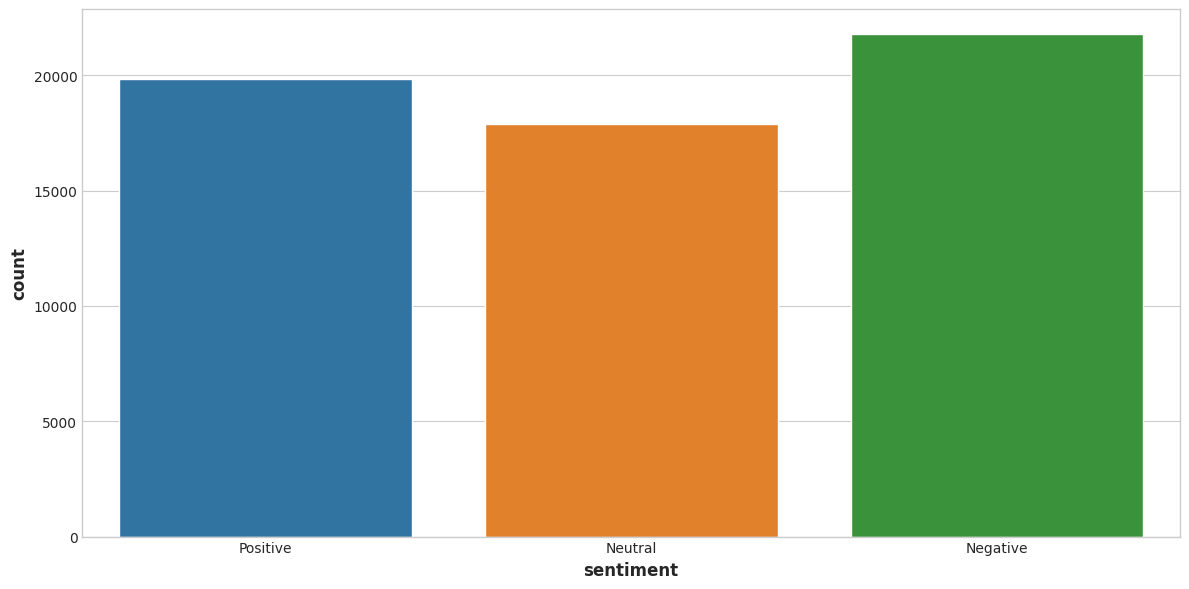

In [15]:
plt.figure(figsize = (12, 6))
sns.countplot(x='sentiment', data = data)

In [16]:
from plotly import graph_objs as go
# Create the funnel area chart
fig = go.Figure(go.Funnelarea(
    labels=temp.sentiment,  # Change from 'label' to 'labels'
    values=temp.content,      # This should be a numerical column
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))

# Show the figure
fig.show()

# Plotting Features

In [17]:
def plotting_sentiment(sentiment):
    word_cloud_sentiment = ''.join(data[data["sentiment"] == sentiment].content)
    
    #Creation of wordcloud
    wordcloud = WordCloud(
        max_font_size = 70,
        max_words=100,
        background_color="black",
        scale=10,
        width=1000,
        height=1000).generate(word_cloud_sentiment)
    
    #Figure properties
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
plotting_sentiment("Positive")

In [ ]:
plotting_sentiment("Negative")

In [ ]:
plotting_sentiment("Neutral")

In [21]:
plot_entity_sentiment=data.groupby(by=['entity', 'sentiment']).count().reset_index()

plot_entity_sentiment

,entity,sentiment,tweetid,content
0,Amazon,Negative,566,566
1,Amazon,Neutral,1210,1210
2,Amazon,Positive,306,306
3,ApexLegends,Negative,577,577
4,ApexLegends,Neutral,927,927
...,...,...,...,...
91,Xbox(Xseries),Neutral,405,405
92,Xbox(Xseries),Positive,746,746
93,johnson&johnson,Negative,818,818
94,johnson&johnson,Neutral,1010,1010


In [ ]:
#Figure of comparison per branch

plt.figure(figsize=(20,10))
sns.barplot(data=plot_entity_sentiment,x="entity",y="tweetid",hue="sentiment")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

In [ ]:
crosstab = pd.crosstab(index=df['entity'], columns=df['sentiment'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Heatmap of Entity Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Entity', fontsize=14)

Text(9.44444444444446, 0.5, 'Entity')

In [ ]:
data_onehot_encoding = pd.get_dummies(data, columns = ['entity', 'sentiment'], drop_first = True)

data_onehot_encoding

In [ ]:
correlation = data_onehot_encoding.drop(columns = ['tweetid', 'content']).corr()
# Set the figure size
plt.figure(figsize=(30, 30))  # Width, Height in inches
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
#Text transformation

#lowercase
data["content"] = data.content.str.lower() 

#converting all to string
data["content"] = [str(dt) for dt in data.content]

#regex
data["content"] = data.content.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [ ]:
data

In [ ]:
data['sentiment'] = data['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

In [ ]:
data

In [ ]:
content_lens = []

for content in data.content:
    tweet_lens = len(content.split())
    content_lens.append(tweet_lens)

data['content_lens'] = content_lens


In [31]:
data

,tweetid,entity,sentiment,content,content_lens
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,10
1,2401,Borderlands,2,i am coming to the borders and i will kill you...,12
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12
...,...,...,...,...,...
984,1373,Battlefield,0,i have noticed streamers i watch who are now p...,44
985,10588,RedDeadRedemption(RDR),1,6th man playing red dead redemption oh shit a...,30
988,7516,LeagueOfLegends,1,suikoden 2 1 alex kidd in miracle world pe...,18
989,5708,HomeDepot,2,thank you to matching funds home depot rw paym...,25


In [32]:
data = data[data.content_lens != 0]

In [33]:
data

,tweetid,entity,sentiment,content,content_lens
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,10
1,2401,Borderlands,2,i am coming to the borders and i will kill you...,12
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12
...,...,...,...,...,...
984,1373,Battlefield,0,i have noticed streamers i watch who are now p...,44
985,10588,RedDeadRedemption(RDR),1,6th man playing red dead redemption oh shit a...,30
988,7516,LeagueOfLegends,1,suikoden 2 1 alex kidd in miracle world pe...,18
989,5708,HomeDepot,2,thank you to matching funds home depot rw paym...,25


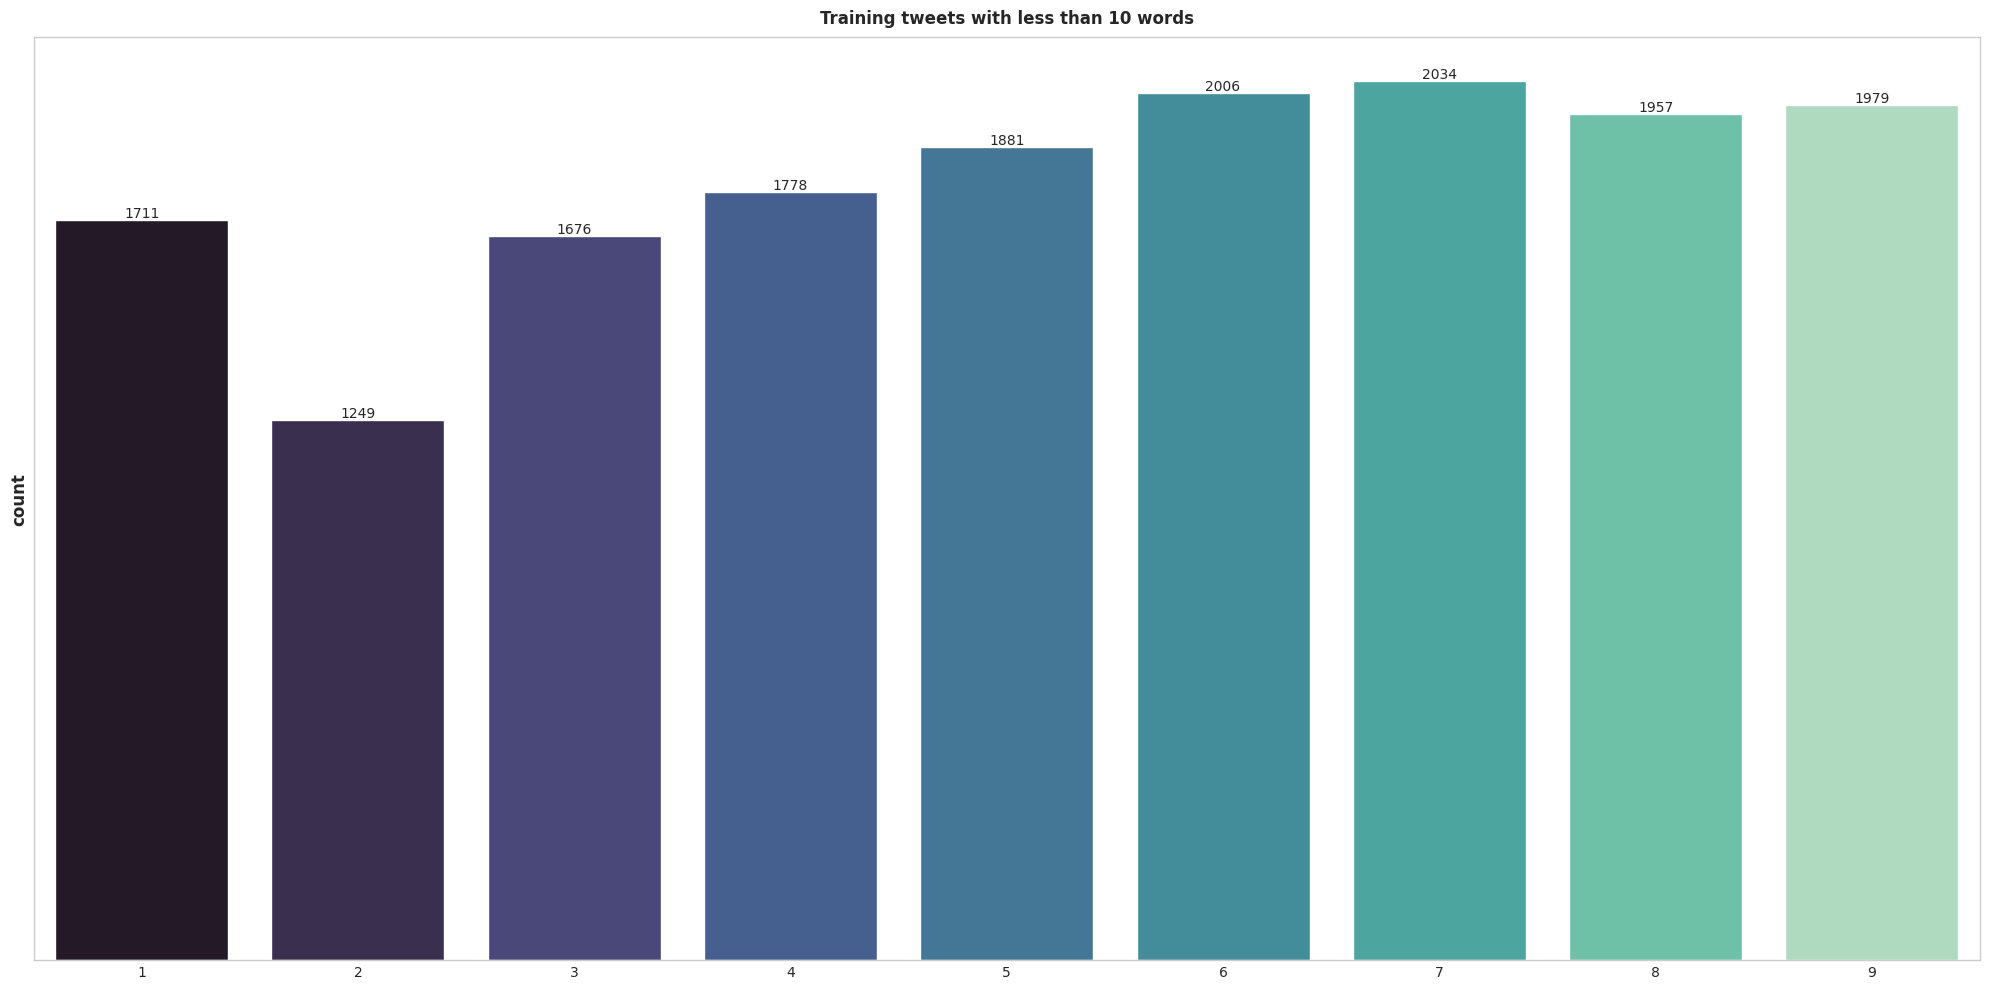

In [34]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='content_lens', data=data[data['content_lens']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Train - Validation - Test split and onehot encoding

In [35]:
data

,tweetid,entity,sentiment,content,content_lens
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,10
1,2401,Borderlands,2,i am coming to the borders and i will kill you...,12
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12
...,...,...,...,...,...
984,1373,Battlefield,0,i have noticed streamers i watch who are now p...,44
985,10588,RedDeadRedemption(RDR),1,6th man playing red dead redemption oh shit a...,30
988,7516,LeagueOfLegends,1,suikoden 2 1 alex kidd in miracle world pe...,18
989,5708,HomeDepot,2,thank you to matching funds home depot rw paym...,25


# Text Analysis

In [37]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in data.content]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  26821


In [38]:
tokens_text[1]

['i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all']

In [39]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

# XGBoost

In [40]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

In [41]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(data.content, data.sentiment, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

In [42]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(X_train)
#Validation data
X_val_bow = bow_counts.transform(X_valid)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.



In [43]:
X_test_bow

<8895x24764 sparse matrix of type '<class 'numpy.int64'>'
	with 97322 stored elements in Compressed Sparse Row format>

In [45]:
#Labels for train and test encoding
y_train_bow = y_train
y_val_bow = y_valid
y_test_bow = y_test

In [46]:
y_test_bow.value_counts() / y_test_bow.shape[0]

sentiment
0    0.365486
2    0.338280
1    0.296234
Name: count, dtype: float64

In [47]:
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_train_bow)
y_test_bow_num=le.transform(y_test_bow)
y_val_bow_num=le.transform(y_val_bow)

In [48]:
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1000,colsample_bytree=0.6, subsample=0.6)
XGB.fit(X_train_bow, y_train_bow_num)
# Prediction
test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2) * 100)

Accuracy:  85.19392917369308


In [49]:
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2) * 100)

Accuracy:  85.05734202833371


In [50]:
test_pred_N = XGB.predict(X_train_bow)
print("Accuracy: ", accuracy_score(y_train_bow_num, test_pred_N) * 100)

Accuracy:  92.31899771111914


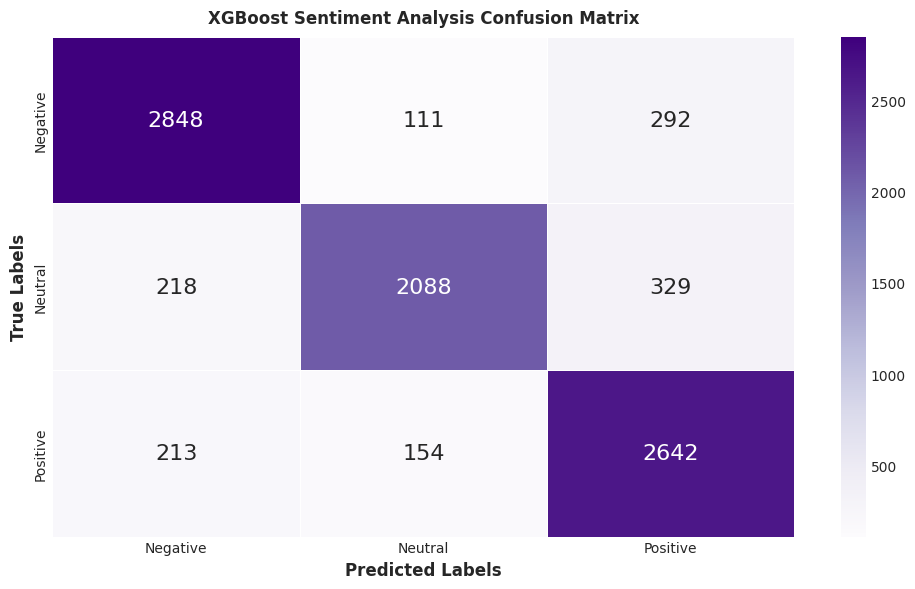

In [60]:
# Confusion matrix for test set
labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(y_test_bow_num, test_pred_2)
# Plotting the confusion matrix with count annotations and color bar
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', linewidths=.5, cbar_kws={'label': ''}, annot_kws={"size": 16},
            xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Sentiment Analysis Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

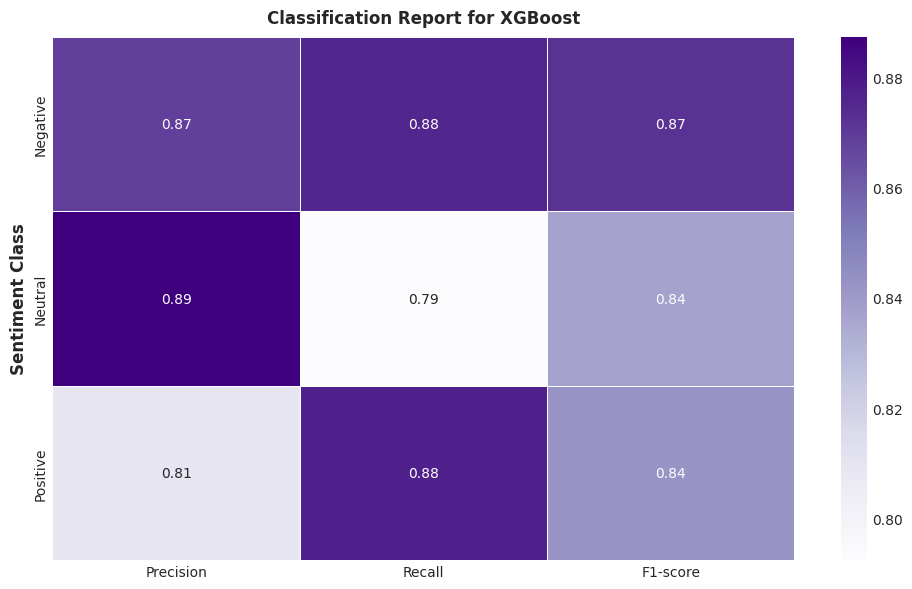

In [70]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate classification report
report = classification_report(y_test_bow_num, test_pred_2, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# Extract metrics
labels = ['Negative', 'Neutral', 'Positive']
precisions = []
recalls = []
f1_scores = []

# Extracting metrics for each class
for label in labels:
    precisions.append(report[label]['precision'])
    recalls.append(report[label]['recall'])
    f1_scores.append(report[label]['f1-score'])

# Create a DataFrame to store metrics
metrics_df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores
}, index=labels)

# Plotting the metrics as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='Purples', fmt='.2f', linewidths=.5, cbar=True)
plt.title('Classification Report for XGBoost')
plt.xlabel('')
plt.ylabel('Sentiment Class')
plt.show()